<a href="https://colab.research.google.com/github/gukouk176-debug/colab2/blob/main/DataScience_13_ipynb_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第13回講義 評価とチューニング2

### 1. 評価手法
+ ROC Curve(ROC曲線)
+ Cross validation

### 2.不均衡データ処理


## 全講義共通初期設定
+ 警告の非表示(実装時は非推奨)
+ numpy pandas小数点以下桁数の表示設定
+ pandas全データ表示設定
+ Google driveへの接続

In [1]:
# ワーニングを非表示にする
# この設定は不都合が見えなくなる為、お勧めしない
# 今回は教育資料用に、出力を簡素化する為に利用する
import warnings
warnings.simplefilter('ignore')

# モジュールの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 小数点以下桁数の表示設定
np.set_printoptions(precision = 3)
pd.options.display.precision = 3

# pandasの全データ表示設定
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#google driveに接続
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#google driveと接続できたかを確認
!ls drive/MyDrive/DataScience

'3(00000).txt'	'3(00004).txt'		       iris.csv		   ファイル_000
'3(00001).txt'	 breast-cancer-wisconsin.csv   titanic_train.csv
'3(00002).txt'	 example.xlsx		      'wine 2.csv'
'3(00003).txt'	 imports-85.csv		       wine.csv


# 1.評価手法

## ROC curve(ROC曲線)

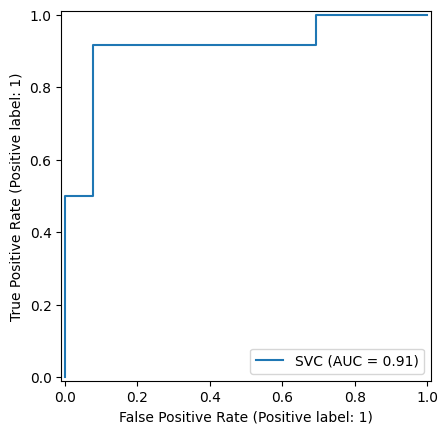

In [4]:
#ROC曲線の描画
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import RocCurveDisplay

#適当にデータセットを生成
X1, y1 = datasets.make_classification(random_state=0)

X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(X1, y1, random_state=0)

sv = svm.SVC(random_state=0)

sv_fit = sv.fit(X1_train, y1_train)

#ROCカーブの生成と描画（from_estimatorを使用）
RocCurveDisplay.from_estimator(sv_fit, X1_test, y1_test)

plt.show()

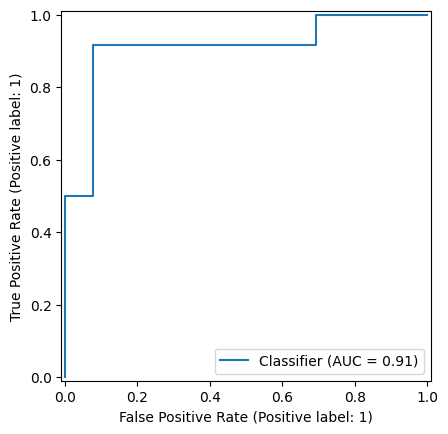

In [5]:
predict = sv.decision_function(X1_test)

#ROCカーブの生成と描画（from_predictionsを使用）
RocCurveDisplay.from_predictions(y1_test, predict)

plt.show()

FPR =  [0.   0.   0.25 0.25 0.5  0.5  1.  ]
TPR =  [0.   0.25 0.5  0.75 0.75 1.   1.  ]
TH =   [inf 0.9 0.8 0.7 0.6 0.5 0.2]
auc:  0.78125


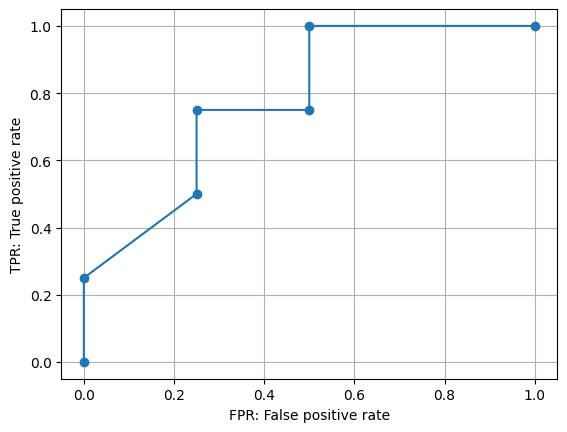

In [6]:
# ROC曲線描画その2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

#適当なスコア値作成
y_true = [0, 0, 0, 0, 1, 1, 1, 1]
y_score = [0.2, 0.3, 0.6, 0.8, 0.8, 0.5, 0.7, 0.9]

#ROC曲線に用いる値を生成
fpr, tpr, thresholds = roc_curve(y_true, y_score)

print('FPR = ', fpr)
print('TPR = ', tpr)
print('TH =  ', thresholds)

auc = metrics.auc(fpr, tpr)
print('auc: ', auc)

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()


### 演習1

AUC（test）:     0.9446


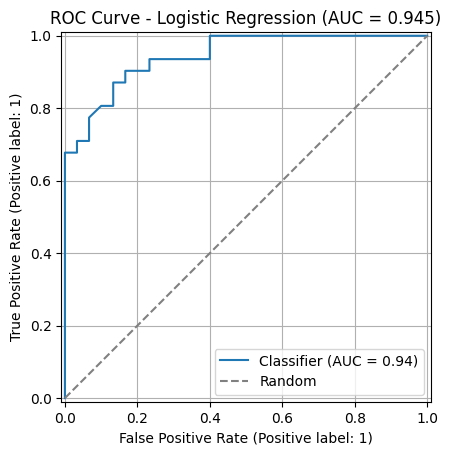

In [7]:
#演習1 : ロジスティック回帰のモデルに対してROC曲線を付け加える
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# --- データ読み込み ---
auto_all = pd.read_csv("/content/drive/MyDrive/DataScience/imports-85.csv", header=None)

auto_all.columns = [
    'symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
    'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height',
    'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore',
    'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'
]

features = ['width', 'length', 'engine-size', 'city-mpg']

auto_all = auto_all.replace('?', np.nan)
auto_all['price'] = pd.to_numeric(auto_all['price'], errors='coerce')
auto_all = auto_all.dropna(subset=['price']).copy()

auto_all['price_over_10K'] = (auto_all['price'] > 10000).astype(int)

auto_df2 = auto_all[features + ['price_over_10K']].copy()
auto_df2[features] = auto_df2[features].apply(pd.to_numeric, errors='coerce')
auto_df2 = auto_df2.dropna()

# 説明変数・目的変数
X = auto_df2.drop('price_over_10K', axis=1)
y = auto_df2['price_over_10K']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# ロジスティック回帰
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


# ROC曲線 + AUC
y_score = lr.predict_proba(X_test)[:, 1]

auc_value = roc_auc_score(y_test, y_score)
print(f"AUC（test）:     {auc_value:.4f}")

RocCurveDisplay.from_predictions(y_test, y_score)
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random")
plt.title(f"ROC Curve - Logistic Regression (AUC = {auc_value:.3f})")
plt.grid(True)
plt.legend()
plt.show()




## Cross Validation

### アヤメデータの準備

In [8]:
#グリッドサーチによるハイパーパラメータの探索
#アヤメのデータに決定木モデルを適用する
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree

#ライブラリpandasを使ったcsvデータの読み込み,sepで区切り記号を設定
ayame_df = pd.read_csv("/content/drive/MyDrive/DataScience/iris.csv", sep=",")

#説明変数、目的変数の設定
X = ayame_df.drop('species', axis =1)
y = ayame_df['species']

print(X.head())
print(y.head())

   sepal.length  sepal.width  petal.length  petal.width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
0    Setosa
1    Setosa
2    Setosa
3    Setosa
4    Setosa
Name: species, dtype: object


In [9]:
#テストデータとトレーニングデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None )

#説明変数の標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [10]:
#Cross validation（交差検証）によるモデルの推定
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#ランダムフォレストのモデル生成
forest = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_leaf=5).fit(X_train, y_train)

# cross validationのモデル生成、cvで分割数を指定
scores = cross_val_score(forest, X, y, cv=10)

#cross validationのそれぞれのスコア（精度）の算出
print('交差検証スコア: {}'.format(scores))
print('交差検証スコア(平均+-標準偏差): {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

交差検証スコア: [1.    0.933 1.    0.933 0.933 0.933 0.867 1.    1.    1.   ]
交差検証スコア(平均+-標準偏差): 0.960+-0.044


### 演習2

In [12]:
#演習2 : Cross validation（交差検証）を実際に使ってみる.モデルもデータセットも自由
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

auto_all = pd.read_csv("/content/drive/MyDrive/DataScience/imports-85.csv", header=None)
auto_all.columns = [
    'symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
    'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height',
    'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore',
    'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'
]
features = ['width', 'length', 'engine-size', 'city-mpg']

auto_all = auto_all.replace('?', np.nan)
auto_all['price'] = pd.to_numeric(auto_all['price'], errors='coerce')
auto_all = auto_all.dropna(subset=['price']).copy()

auto_all['price_over_10K'] = (auto_all['price'] > 10000).astype(int)

auto_df2 = auto_all[features + ['price_over_10K']].copy()
auto_df2[features] = auto_df2[features].apply(pd.to_numeric, errors='coerce')
auto_df2 = auto_df2.dropna()

# 説明変数・目的変数
X = auto_df2[features]
y = auto_df2['price_over_10K']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

forest = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=5,
    random_state=0
)

# cross validationのモデル生成、cvで分割数を指定
scores = cross_val_score(forest, X, y, cv=10)

#cross validationのそれぞれのスコア（精度）の算出
print('交差検証スコア: {}'.format(scores))
print('交差検証スコア(平均+-標準偏差): {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))


交差検証スコア: [0.905 0.8   0.95  0.9   1.    0.95  0.9   0.7   0.8   0.9  ]
交差検証スコア(平均+-標準偏差): 0.880+-0.084


# 2. 不均衡データ処理

## SMOTE(Over sampling)
データは前作業で利用した breast-cancerデータを利用する

In [13]:
#データ処理したb乳がんデータセットを用いてSVMを実行．これに対してvalidation cruveを使う
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

#乳がんデータの読み込み
bc_source_df = pd.read_csv('/content/drive/MyDrive/DataScience/breast-cancer-wisconsin.csv',sep=',')

#前処理
bc_df = bc_source_df.replace("?", "5")
bc_df = bc_df.astype({'Bare Nuclei':'int64'})

#説明変数の設定
X_bc = bc_df.iloc[:, [1,2,3,4,5,6,7,8,9]]

#目的変数の設定
y_bc = bc_df.iloc[:,[10]]


In [14]:
#SMOTE(over sampling)のインポート
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

#smoteのモデル生成
sm = SMOTE(k_neighbors=10,sampling_strategy='minority')

#smoteによる均衡データ作成
x_resampled, y_resampled = sm.fit_resample(X_bc.values, y_bc.values)


In [15]:
#データセットのクラス別の個数確認
print('元のデータセットの目的変数別の個数')
print(bc_source_df['Class'].value_counts())

u, counts = np.unique(y_resampled, return_counts=True)

print('smote後の個数')
print(u[0], '  ', counts[0])
print(u[1], '  ', counts[1])

元のデータセットの目的変数別の個数
Class
2    458
4    241
Name: count, dtype: int64
smote後の個数
2    458
4    458


In [16]:
help(SMOTE)

Help on class SMOTE in module imblearn.over_sampling._smote.base:

class SMOTE(BaseSMOTE)
 |  SMOTE(*, sampling_strategy='auto', random_state=None, k_neighbors=5)
 |
 |  Class to perform over-sampling using SMOTE.
 |
 |  This object is an implementation of SMOTE - Synthetic Minority
 |  Over-sampling Technique as presented in [1]_.
 |
 |  Read more in the :ref:`User Guide <smote_adasyn>`.
 |
 |  Parameters
 |  ----------
 |  sampling_strategy : float, str, dict or callable, default='auto'
 |      Sampling information to resample the data set.
 |
 |      - When ``float``, it corresponds to the desired ratio of the number of
 |        samples in the minority class over the number of samples in the
 |        majority class after resampling. Therefore, the ratio is expressed as
 |        :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
 |        number of samples in the minority class after resampling and
 |        :math:`N_{M}` is the number of samples in the majority clas

In [17]:
#ADASYNによる均衡データ作成
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()

x_ad_resampled, y_ad_resampled = sm.fit_resample(X_bc.values, y_bc.values)

In [18]:
#データセットのクラス別の個数確認
print('元のデータセットの目的変数別の個数')
print(bc_source_df['Class'].value_counts())

u, counts = np.unique(y_ad_resampled, return_counts=True)

print('ADASYN後の個数')
print(u[0], '  ', counts[0])
print(u[1], '  ', counts[1])

元のデータセットの目的変数別の個数
Class
2    458
4    241
Name: count, dtype: int64
ADASYN後の個数
2    458
4    458


In [19]:
# RandomOverSamplerによるデータの水増し
from imblearn.over_sampling import RandomOverSampler

# 正例を10％まであげる
ros = RandomOverSampler()
#ratio = {0:BC_X.shape[0], 1:BC_X.shape[0]//9}, random_state = 0)

# 学習用データに反映
X_train_resampled, y_train_resampled = ros.fit_resample(X_bc.values, y_bc.values)

In [20]:
#データセットのクラス別の個数確認
print('元のデータセットの目的変数別の個数')
print(bc_source_df['Class'].value_counts())

u, counts = np.unique(y_train_resampled, return_counts=True)

print('RandomOverSampler後の個数')
print(u[0], '  ', counts[0])
print(u[1], '  ', counts[1])

元のデータセットの目的変数別の個数
Class
2    458
4    241
Name: count, dtype: int64
RandomOverSampler後の個数
2    458
4    458


## Under sampling(多数派クラスを減らす)

In [21]:
#Under sampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

# Under samplingによるデータ作成
x2_resampled, y2_resampled = rus.fit_resample(X_bc.values, y_bc.values)


In [22]:
#データセットのクラス別の個数確認
print('元のデータセットの目的変数別の個数')
print(bc_source_df['Class'].value_counts())

u, counts = np.unique(y2_resampled, return_counts=True)

print('under sampling後の個数')
print(u[0], '  ', counts[0])
print(u[1], '  ', counts[1])

元のデータセットの目的変数別の個数
Class
2    458
4    241
Name: count, dtype: int64
under sampling後の個数
2    241
4    241


In [23]:
help(RandomUnderSampler)

Help on class RandomUnderSampler in module imblearn.under_sampling._prototype_selection._random_under_sampler:

class RandomUnderSampler(imblearn.under_sampling.base.BaseUnderSampler)
 |  RandomUnderSampler(*, sampling_strategy='auto', random_state=None, replacement=False)
 |
 |  Class to perform random under-sampling.
 |
 |  Under-sample the majority class(es) by randomly picking samples
 |  with or without replacement.
 |
 |  Read more in the :ref:`User Guide <controlled_under_sampling>`.
 |
 |  Parameters
 |  ----------
 |  sampling_strategy : float, str, dict, callable, default='auto'
 |      Sampling information to sample the data set.
 |
 |      - When ``float``, it corresponds to the desired ratio of the number of
 |        samples in the minority class over the number of samples in the
 |        majority class after resampling. Therefore, the ratio is expressed as
 |        :math:`\alpha_{us} = N_{m} / N_{rM}` where :math:`N_{m}` is the
 |        number of samples in the minori

### 演習３

In [27]:
#演習3：over sampling or under samplingを使用したのち、モデルで学習して結果を出す
#使用していない場合と精度を比べてみる
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

auto_all = pd.read_csv("/content/drive/MyDrive/DataScience/imports-85.csv", header=None)

auto_all.columns = [
    'symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
    'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height',
    'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore',
    'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'
]

features = ['width', 'length', 'engine-size', 'city-mpg']

auto_all = auto_all.replace('?', np.nan)
auto_all['price'] = pd.to_numeric(auto_all['price'], errors='coerce')
auto_all = auto_all.dropna(subset=['price']).copy()

auto_all['price_over_10K'] = (auto_all['price'] > 10000).astype(int)

auto_df2 = auto_all[features + ['price_over_10K']].copy()
auto_df2[features] = auto_df2[features].apply(pd.to_numeric, errors='coerce')
auto_df2 = auto_df2.dropna()

X = auto_df2[features]
y = auto_df2['price_over_10K']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

forest0 = RandomForestClassifier(
    n_estimators=100, max_depth=7, min_samples_leaf=5, random_state=0
)
forest0.fit(X_train, y_train)

print("SMOTEなし")
print('正解率（test):  {:.4f}'.format(forest0.score(X_test, y_test)))

print()

sm = SMOTE(k_neighbors=10, sampling_strategy='minority', random_state=0)
x_resampled, y_resampled = sm.fit_resample(X_train.values, y_train.values)
print('元のデータセットの目的変数別の個数（train）')
print(y_train.value_counts())

u, counts = np.unique(y_resampled, return_counts=True)

print('smote後の個数（train resampled）')
print(u[0], '  ', counts[0])
print(u[1], '  ', counts[1])

print()

forest2 = RandomForestClassifier(
    n_estimators=100, max_depth=7, min_samples_leaf=5, random_state=0
)
forest2.fit(x_resampled, y_resampled)

# テストデータによる精度の検証
print("SMOTEあり")
print('正解率（test):  {:.4f}'.format(forest2.score(X_test, y_test)))



SMOTEなし
正解率（test):  0.9024

元のデータセットの目的変数別の個数（train）
price_over_10K
1    82
0    78
Name: count, dtype: int64
smote後の個数（train resampled）
0    82
1    82

SMOTEあり
正解率（test):  0.9024


#■■演習解答
+ タイタニックデータを使用

##演習1解答

In [ ]:
#タイタニックデータの読み込み
import pandas as pd

titanic_df = pd.read_csv('/content/drive/MyDrive/DataScience/titanic_train.csv',sep=',')

#すべての欠損値を平均で置換する、※数値型のみ
titanic_df_fill = titanic_df.fillna(titanic_df.mean())

#変数の設定
Titanic_X = titanic_df_fill.iloc[:, [2,5,6,7,9]]
Titanic_Y = titanic_df_fill.iloc[:,[1]]

#トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(Titanic_X, Titanic_Y, test_size=0.2, random_state=None )

#モデルのインスタンス生成
tree_model = tree.DecisionTreeClassifier(max_depth=3)
#学習
tree_model.fit(X_train,y_train)

In [ ]:
#演習1 : ロジスティック回帰のモデルに対してROC曲線を付け加える

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import numpy as np

# ロジスティック回帰のモデル（インスタンス）生成
lr = LogisticRegression()
#トレーニングデータによる学習
lr_fit = lr.fit(X_train, y_train)

#トレーニングデータによるフィッティング結果とテストデータによる学習モデルの精度の検証
print('正解率（train):  {:.4f}'.format(lr.score(X_train, y_train)))
print('正解率（test):  {:.4f}'.format(lr.score(X_test, y_test)))

#ROCカーブの生成と描画（from_estimatorを使用）
RocCurveDisplay.from_estimator(lr_fit, X_test, y_test)

plt.show()

##演習2解答

In [ ]:
#演習2 : Cross validation（交差検証）を実際に使ってみる.モデルもデータセットも自由


from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#ランダムフォレストのモデル生成
forest = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_leaf=5).fit(X_train, y_train)

# cross validationのモデル生成、cvで分割数を指定
scores = cross_val_score(forest, X, y, cv=10)

#cross validationのそれぞれのスコア（精度）の算出
print('交差検証スコア: {}'.format(scores))
print('交差検証スコア(平均+-標準偏差): {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

##演習3解答

In [26]:
#演習3：over sampling or under samplingを使用したのち、モデルで学習して結果を出す
#使用していない場合と精度を比べてみる

#SMOTE(over sampling)のインポート
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

#トレーニングデータとテストデータに分割
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None )

#smoteのモデル生成
sm = SMOTE(k_neighbors=10,sampling_strategy='minority')

#smoteによる均衡データ作成
x_resampled, y_resampled = sm.fit_resample(X_train.values, y_train.values)

#データセットのクラス別の個数確認
print('元のデータセットの目的変数別の個数')
print(y_train['Survived'].value_counts())

u, counts = np.unique(y_resampled, return_counts=True)

print('smote後の個数')
print(u[0], '  ', counts[0])
print(u[1], '  ', counts[1])

print()

#ランダムフォレストのモデル生成
forest2 = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=5)

forest2.fit(x_resampled, y_resampled)

#テストデータによる学習モデルの精度の検証
print('正解率（test):  {:.4f}'.format(forest2.score(X_test, y_test)))

元のデータセットの目的変数別の個数


KeyError: 'Survived'